In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pm4py
import numpy as np
import datetime
pd.set_option("display.max_rows", None)
from collections import Counter
import operator
import pickle
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
np.random.seed(2)
#pd.set_option('display.max_columns', None)

In [49]:
df = pd.read_csv('BPI_Challenge_2012.xes.gz_UNPACKED.csv', index_col=[0])
start = time.time()
df.drop(columns=['org:resource'], inplace=True)
df['next_event'] = df['concept:name'].shift(-1)
df['previous_event'] = df['concept:name'].shift(1)
df['pp_event'] = df['concept:name'].shift(2)
df['ppp_event'] = df['concept:name'].shift(3)
df['p_lifecycle:transition'] = df['lifecycle:transition'].shift(1)
df['next_case'] = df['case:concept:name'].shift(-1).fillna(0)
df['next_case1'] = df['next_case'].shift(-1).fillna(0)
df['datetime'] = pd.to_datetime(df['time:timestamp'], errors='coerce', utc=True)
df['weekday'] = df['datetime'].dt.weekday
df['previous_weekday'] = df['weekday'].shift(1)
df['hour'] =  df['datetime'].dt.hour
df['minute'] =  df['datetime'].dt.minute
df['month'] =  df['datetime'].dt.month
df['next_datetime'] = df['datetime'].shift(-1)
df['timedelta'] = (df['next_datetime'] - df['datetime']).astype('timedelta64[s]')
df = df[(df['case:concept:name'].astype(int)) == (df['next_case'].astype(int))]
df['previous_timedelta'] = df['timedelta'].shift(1)
df['pp_timedelta'] = df['timedelta'].shift(2)
df['ppp_timedelta'] = df['timedelta'].shift(3)
print(len(df))
df.dropna(inplace=True)
df.iloc[:10]
dfxx = df[['hour', 'previous_timedelta', 'pp_timedelta']]
dfx = df[['concept:name', 'previous_event', 'pp_event', 'weekday']]
dfy = (df[['timedelta']])
valx = dfx
valy = dfy
dummies = pd.get_dummies(dfx.astype('str'))
dfx = dfxx.join(dummies)
trainlen = int(len(df)*0.7)
x_train, y_train = dfx[:trainlen], dfy[:trainlen]
x_test, y_test = dfx[trainlen:], dfy[trainlen:]
df2 = x_train.join(y_train)
dftest = x_test.join(y_test)
valy = y_test
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
print(len(df))
x_train


249113
249110


<tf.Tensor: shape=(174377, 82), dtype=float64, numpy=
array([[2.20000e+01, 0.00000e+00, 5.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [9.00000e+00, 3.94270e+04, 0.00000e+00, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [9.00000e+00, 3.56000e+02, 3.94270e+04, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       ...,
       [1.40000e+01, 3.48382e+05, 1.62000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.40000e+01, 4.50000e+01, 3.48382e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.50000e+01, 2.61859e+05, 4.50000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])>

In [50]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
#splitter NN
lrelu = tf.keras.layers.LeakyReLU(alpha=0.3)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],1)),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.Dense(228, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(48, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])
model.summary()
loss_fn = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

ftrl = tf.keras.optimizers.Ftrl(
    learning_rate=0.1,
    learning_rate_power=-0.5,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.01,
    l2_regularization_strength=0.01,
    name="Ftrl",
    l2_shrinkage_regularization_strength=0.01,
    beta=0.1)

msle = tf.keras.losses.MeanSquaredLogarithmicError()
def loss_comb(y_true, y_pred):
    return 1*msle(y_true, y_pred) + 0.00000001*(loss_fn(y_true, y_pred))

model.compile(optimizer=ftrl,
              loss=loss_fn,
              metrics=['mean_absolute_error'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 82)                0         
                                                                 
 batch_normalization_9 (Batc  (None, 82)               328       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 228)               18924     
                                                                 
 batch_normalization_10 (Bat  (None, 228)              912       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 128)               29312     
                                                                 
 batch_normalization_11 (Bat  (None, 128)             

In [52]:
#splitter NN
model.fit(x_train, y_train, epochs=15, batch_size=512, validation_split=0.0, shuffle=True)

Epoch 1/15
341/341 [==============================] - 6s 13ms/step - loss: 18612322304.0000 - mean_absolute_error: 43976.7695
Epoch 2/15
341/341 [==============================] - 5s 13ms/step - loss: 16822422528.0000 - mean_absolute_error: 40811.5625
Epoch 3/15
341/341 [==============================] - 5s 14ms/step - loss: 16703824896.0000 - mean_absolute_error: 40143.5078
Epoch 4/15
341/341 [==============================] - 5s 13ms/step - loss: 16613590016.0000 - mean_absolute_error: 39655.9180
Epoch 5/15
341/341 [==============================] - 4s 13ms/step - loss: 16562232320.0000 - mean_absolute_error: 39740.1562
Epoch 6/15
341/341 [==============================] - 4s 13ms/step - loss: 16561988608.0000 - mean_absolute_error: 39596.1133
Epoch 7/15
341/341 [==============================] - 4s 13ms/step - loss: 16530161664.0000 - mean_absolute_error: 39543.1250
Epoch 8/15
341/341 [==============================] - 4s 13ms/step - loss: 16508503040.0000 - mean_absolute_error: 393

In [53]:
model.evaluate(x_test,  y_test, verbose=2)

2336/2336 - 11s - loss: 11841302528.0000 - mean_absolute_error: 34669.8516 - 11s/epoch - 5ms/step


[11841302528.0, 34669.8515625]

1557/1557 - 6s - loss: 16145751040.0000 - mean_absolute_error: 38487.3203 - 6s/epoch - 4ms/step
[16145751040.0, 38487.3203125] 100 epoch

1557/1557 - 6s - loss: 12990233600.0000 - mean_absolute_error: 39434.7891 - 6s/epoch - 4ms/step
[12990233600.0, 39434.7890625] 10 epoch

1557/1557 - 6s - loss: 12379001856.0000 - mean_absolute_error: 39955.4883 - 6s/epoch - 4ms/step
[12379001856.0, 39955.48828125] 5 epoch

1557/1557 - 7s - loss: 16281440256.0000 - mean_absolute_error: 34248.9844 - 7s/epoch - 4ms/step
[16281440256.0, 34248.984375] rmsprop 5epoch

1557/1557 - 6s - loss: 13425792000.0000 - mean_absolute_error: 38229.3945 - 6s/epoch - 4ms/step
[13425792000.0, 38229.39453125] ftrl 5 epoch

1557/1557 - 6s - loss: 12477991936.0000 - mean_absolute_error: 38378.7773 - 6s/epoch - 4ms/step
[12477991936.0, 38378.77734375] ftrl 25 epoch

1557/1557 - 6s - loss: 13436874752.0000 - mean_absolute_error: 37503.7383 - 6s/epoch - 4ms/step
[13436874752.0, 37503.73828125] ftrl 20 epoch 

1557/1557 - 6s - loss: 12613310464.0000 - mean_absolute_error: 36718.5391 - 6s/epoch - 4ms/step
[12613310464.0, 36718.5390625] ftrl shrinkage 0.1 beta 0.1 20 epoch 

1557/1557 - 6s - loss: 22985072640.0000 - mean_absolute_error: 38325.5352 - 6s/epoch - 4ms/step
[22985072640.0, 38325.53515625] 100 epoch

1557/1557 - 5s - loss: 11458832384.0000 - mean_absolute_error: 36769.4922 - 5s/epoch - 3ms/step
[11458832384.0, 36769.4921875] 20 epoch

1557/1557 - 6s - loss: 10764874752.0000 - mean_absolute_error: 33928.1797 - 6s/epoch - 4ms/step
[10764874752.0, 33928.1796875] 5 epoch

1557/1557 - 7s - loss: 10972633088.0000 - mean_absolute_error: 34962.5430 - 7s/epoch - 4ms/step
[10972633088.0, 34962.54296875] l2 in model, no dropout

1557/1557 - 6s - loss: 10712907776.0000 - mean_absolute_error: 33294.6133 - 6s/epoch - 4ms/step
[10712907776.0, 33294.61328125] 0.01 l1, l2

1557/1557 - 6s - loss: 12210000896.0000 - mean_absolute_error: 44738.8945 - 6s/epoch - 4ms/step
[12210000896.0, 44738.89453125]

1557/1557 - 6s - loss: 10496494592.0000 - mean_absolute_error: 31814.3359 - 6s/epoch - 4ms/step
[10496494592.0, 31814.3359375]

2336/2336 - 10s - loss: 5.0835 - mean_absolute_error: 36537.7109 - 10s/epoch - 4ms/step
[5.083494186401367, 36537.7109375]

1557/1557 - 7s - loss: 11157584896.0000 - mean_absolute_error: 36030.8945 - 7s/epoch - 4ms/step
[11157584896.0, 36030.89453125]

In [54]:
predictions = model(x_test).numpy()

In [55]:
predictions_train = model(x_train).numpy()
predictions_test = model(x_test).numpy()

In [56]:
df2['predictions_train'] = predictions_train
dftest['predictions_test'] = predictions_test

In [57]:
#test and train split on split-NN prediction
p=65
df2_short = df2[df2['predictions_train'] < np.nanpercentile(df2['predictions_train'], p)]
df2_long = df2[df2['predictions_train'] >= np.nanpercentile(df2['predictions_train'], p)]
dftest_long = dftest[dftest['predictions_test'] >= np.nanpercentile(dftest['predictions_test'], p)]
dftest_short = dftest[dftest['predictions_test'] < np.nanpercentile(dftest['predictions_test'], p)]
print(np.nanpercentile(dftest['predictions_test'], p))
print(np.nanpercentile(df2['predictions_train'], p))
df2.iloc[:100]

1095.4650878906307
1831.7134277343766


,hour,previous_timedelta,pp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,...,pp_event_W_Wijzigen contractgegevens,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_train
3,22,0.0,53.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,39427.0,32337.482422
4,9,39427.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,356.0,463.125977
5,9,356.0,39427.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,145.0,144.749069
6,9,145.0,356.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,232.292267
7,9,0.0,145.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1.0,299.702454
8,9,1.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,176.072372
9,9,0.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,262.187103
10,9,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2.0,295.962006
11,9,2.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1827.0,302569.281250
12,10,1827.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,87.0,529.231567


In [58]:
#df2_long.iloc[:100]

In [59]:
#creates short training data
x = df2_short.drop(columns=['timedelta', 'predictions_train'])
y = pd.DataFrame(df2_short['timedelta'])
x_train, y_train = x, y
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_train

<tf.Tensor: shape=(113345, 82), dtype=float64, numpy=
array([[9.00000e+00, 3.94270e+04, 0.00000e+00, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [9.00000e+00, 3.56000e+02, 3.94270e+04, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [9.00000e+00, 1.45000e+02, 3.56000e+02, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       ...,
       [1.30000e+01, 6.06735e+05, 2.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.40000e+01, 3.48382e+05, 1.62000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.50000e+01, 2.61859e+05, 4.50000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])>

In [60]:
#SHORT MODEL 
model_short = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],1)),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dense(48, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model_short.summary()

loss_fn = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

ftrl = tf.keras.optimizers.Ftrl(
    learning_rate=0.1,
    learning_rate_power=-0.7,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.01,
    l2_regularization_strength=0.01,
    name="Ftrl",
    l2_shrinkage_regularization_strength=0.01,
    beta=0.1)

model_short.compile(optimizer=ftrl,
              loss=loss_comb,
              metrics=['mean_absolute_error'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 82)                0         
                                                                 
 batch_normalization_13 (Bat  (None, 82)               328       
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 128)               10624     
                                                                 
 dense_20 (Dense)            (None, 48)                6192      
                                                                 
 dense_21 (Dense)            (None, 48)                2352      
                                                                 
 dense_22 (Dense)            (None, 1)                 49        
                                                      

In [61]:
model_short.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.1, shuffle=True)

Epoch 1/10
200/200 [==============================] - 4s 14ms/step - loss: 3.4773 - mean_absolute_error: 386.4359 - val_loss: 2.9091 - val_mean_absolute_error: 425.5596
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 2.1405 - mean_absolute_error: 379.0329 - val_loss: 2.1596 - val_mean_absolute_error: 421.0481
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0726 - mean_absolute_error: 378.0451 - val_loss: 2.0611 - val_mean_absolute_error: 419.9269
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 2.0255 - mean_absolute_error: 377.4047 - val_loss: 2.0009 - val_mean_absolute_error: 419.1684
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 1.9747 - mean_absolute_error: 376.7639 - val_loss: 1.9521 - val_mean_absolute_error: 418.2021
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 1.9125 - mean_absolute_error: 376.0090 - val_loss: 1.8732 - val_mean_absolute_er

In [62]:
predictions_short = model_short(x_train).numpy()

In [63]:
df2_short['predictions_short'] = predictions_short

C:\Users\20175892\AppData\Local\Temp\ipykernel_9144\3082676455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_short['predictions_short'] = predictions_short


In [64]:
print('short error old', np.square(abs(df2_short['timedelta'] - df2_short['predictions_train'])).mean())

short error old 46121455.799814954


In [65]:
np.square(abs(df2_short['timedelta'] - df2_short['predictions_short'])).mean()

46267807.2666745

In [66]:
np.square(np.log(df2_short['timedelta'] + 1.) - np.log(df2_short['predictions_short'] + 1.)).mean()

1.3416453749337849

In [67]:
np.square(np.log(df2_short['timedelta'] + 1.) - np.log(df2_short['predictions_train'] + 1.)).mean()

C:\Users\20175892\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


14.384026546289894

In [68]:
#create train data long
x = df2_long.drop(columns=['timedelta', 'predictions_train'])
y = pd.DataFrame(df2_long['timedelta'])
x_train, y_train = x[:trainlen], y[:trainlen]
x_test, y_test = x[trainlen:], y[trainlen:]
valy = y_test
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [69]:
#model long
model_long = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(x_train.shape[1],1)),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.Dense(228, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(48, activation='swish', activity_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(48, activation='swish'),
  tf.keras.layers.Dense(1, activation='linear')
])

model_long.summary()

loss_fn = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

ftrl = tf.keras.optimizers.Ftrl(
    learning_rate=0.1,
    learning_rate_power=-0.5,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.01,
    l2_regularization_strength=0.01,
    name="Ftrl",
    l2_shrinkage_regularization_strength=0.01,
    beta=0.1)

def loss_comb(y_true, y_pred):
    return 1*msle(y_true, y_pred) + 0.01*(loss_fn(y_true, y_pred))

model_long.compile(optimizer=ftrl,
              loss=loss_fn,
              metrics=['mean_absolute_error'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 82)                0         
                                                                 
 batch_normalization_14 (Bat  (None, 82)               328       
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 228)               18924     
                                                                 
 batch_normalization_15 (Bat  (None, 228)              912       
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 128)               29312     
                                                                 
 batch_normalization_16 (Bat  (None, 128)             

In [70]:
#model_long.fit(x_train, y_train, epochs=1, batch_size=512, validation_split=0.1, shuffle=True)

In [71]:
predictions_long = model(x_train).numpy()
df2_long['predictions_long'] = predictions_long
np.square((abs(df2_long['timedelta'] - df2_long['predictions_long']))).mean()

C:\Users\20175892\AppData\Local\Temp\ipykernel_9144\2783323390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_long['predictions_long'] = predictions_long


46037534835.12167

In [72]:
np.square(abs(df2_long['timedelta'] - df2_long['predictions_train'])).mean()

46037534835.12167

In [73]:
np.square(np.log(df2_long['timedelta'] + 1.) - np.log(df2_long['predictions_long'] + 1.)).mean()

17.92267961012077

In [74]:
np.square(np.log(df2_long['timedelta'] + 1.) - np.log(df2_long['predictions_train'] + 1.)).mean()

17.92267961012077

In [75]:
df2_long['mse'] = np.square((abs(df2_long['timedelta'] - df2_long['predictions_long'])))
#df2_long.iloc[:100]

C:\Users\20175892\AppData\Local\Temp\ipykernel_9144\4084488403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_long['mse'] = np.square((abs(df2_long['timedelta'] - df2_long['predictions_long'])))


In [76]:
x = dftest_short.drop(columns=['timedelta', 'predictions_test'])
y = pd.DataFrame(dftest_short['timedelta'])
x_train, y_train = x, y
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

In [77]:
predictions_test_short = model_short(x_train).numpy()
dftest_short['predictions'] = predictions_test_short
dftest_short.iloc[:10]

C:\Users\20175892\AppData\Local\Temp\ipykernel_9144\4120505552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_short['predictions'] = predictions_test_short


,hour,previous_timedelta,pp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_test,predictions
183419,11,331833.0,70.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,67.0,173.404938,58.133064
183423,8,410760.0,38.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,257.0,176.384903,54.026051
183425,8,343902.0,257.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,204.707794,0.219805
183426,8,0.0,343902.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,160.070190,0.219805
183428,23,0.0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.0,247.930115,0.219805
183429,23,0.0,0.0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,49.0,246.203873,27.384792
183430,23,49.0,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.0,-104.693726,0.219805
183432,12,46607.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,604.0,431.938354,120.042725
183435,12,48.0,7.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,30.0,115.881561,104.061592
183436,12,30.0,48.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.0,210.356766,0.219805


In [78]:
x = dftest_long.drop(columns=['timedelta', 'predictions_test'])
y = pd.DataFrame(dftest_long['timedelta'])
x_train, y_train = x, y
#print(x_train.iloc[:10])
columns = y_train.columns
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

In [79]:
predictions_test_long = model(x_train).numpy()
dftest_long['predictions'] = predictions_test_long
dftest_long.iloc[:100]

C:\Users\20175892\AppData\Local\Temp\ipykernel_9144\547458668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_long['predictions'] = predictions_test_long


,hour,previous_timedelta,pp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_test,predictions
183418,15,70.0,261859.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,331833.0,215699.546875,215699.546875
183420,11,67.0,331833.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,357050.0,138191.671875,138191.671875
183421,14,357050.0,67.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,38.0,1417.247925,1417.247925
183422,14,38.0,357050.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,410760.0,212714.140625,212714.140625
183424,8,257.0,410760.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,343902.0,178767.406250,178767.406250
183431,23,0.0,49.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,46607.0,59755.960938,59755.960938
183433,12,604.0,46607.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,7.0,43305.636719,43305.636719
183434,12,7.0,604.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,48.0,14092.798828,14092.798828
183441,12,1.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,620022.0,252301.687500,252301.687500
183443,16,118.0,620022.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,96614.0,254131.218750,254131.218750


In [80]:
#eval long
print('short old test log', np.square(np.log2(dftest_short['timedelta'] + 1.) - np.log2(dftest_short['predictions_test'] + 1.)).mean())
print('short new test log',np.square(np.log2(dftest_short['timedelta'] + 1.) - np.log2(dftest_short['predictions'] + 1.)).mean(), '\n')
print('short old test mse',np.square(abs(dftest_short['timedelta'] - dftest_short['predictions_test'])).mean())
print('short new test mse',np.square(abs(dftest_short['timedelta'] - dftest_short['predictions'])).mean(), '\n')
print('long old test mse', np.square(abs(dftest_long['timedelta'] - dftest_long['predictions_test'])).mean())
print('long new test mse', np.square(abs(dftest_long['timedelta'] - dftest_long['predictions'])).mean(), '\n')
print('long old test log', np.square(np.log2(dftest_long['timedelta'] + 1.) - np.log2(dftest_long['predictions_test'] + 1.)).mean())
print('long new test log', np.square(np.log2(dftest_long['timedelta'] + 1.) - np.log2(dftest_long['predictions'] + 1.)).mean())

short old test log 29.392366747694997
short new test log 2.8926320810343524 

short old test mse 54903548.656870864
short new test mse 55061259.97246895 

long old test mse 33729810784.80958
long new test mse 33729810784.80958 

long old test log 37.81025131949279
long new test log 37.81025131949279


C:\Users\20175892\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [81]:
dftest_all = pd.concat([dftest_long, dftest_short], sort=False).sort_index()
dftest_all['error'] = abs(dftest_all['predictions'] - dftest_all['timedelta'])
dftest_all.iloc[3000:3100]

,hour,previous_timedelta,pp_timedelta,concept:name_A_ACCEPTED,concept:name_A_ACTIVATED,concept:name_A_APPROVED,concept:name_A_CANCELLED,concept:name_A_DECLINED,concept:name_A_FINALIZED,concept:name_A_PARTLYSUBMITTED,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,timedelta,predictions_test,predictions,error
186562,17,47.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0.0,129.689224,0.219805,0.219805
186563,17,0.0,47.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0.0,165.090240,0.219805,0.219805
186564,17,0.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1.0,180.275696,0.757748,0.242252
186565,17,1.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,612574.0,230285.375000,230285.375000,382288.625000
186566,19,612574.0,1.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,93.0,274.671753,61.679005,31.320995
186567,19,93.0,612574.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,73179.0,285872.968750,285872.968750,212693.968750
186568,15,73179.0,93.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,64.0,685.407715,66.907135,2.907135
186569,15,64.0,73179.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1665.0,208753.156250,208753.156250,207088.156250
186570,16,1665.0,64.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,29.0,127401.734375,127401.734375,127372.734375
186571,16,29.0,1665.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,232215.0,173668.140625,173668.140625,58546.859375


In [82]:
np.square(abs(dftest_all['timedelta'] - dftest_all['predictions_test'])).mean()

11841323852.6196

In [83]:
np.square(abs(dftest_all['timedelta'] - dftest_all['predictions'])).mean()

11841426364.02509

In [84]:
np.square(np.log(dftest_all['timedelta'] + 1.) - np.log(dftest_all['predictions_test'] + 1.)).mean()

C:\Users\20175892\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


15.55414036891976

In [85]:
np.square(np.log(dftest_all['timedelta'] + 1.) - np.log(dftest_all['predictions'] + 1.)).mean()

7.261571240536646

In [86]:
#mean absolute error
def hourstomin(time):
    hours = str(int(time))
    minutes = str(int(time*60) % 60).format(".2f")
    seconds = str(int(time*3600) % 60)
    return (hours+'H'+minutes+'m'+seconds+'s')
print('root mean square eror new:',hourstomin(np.power(np.square(dftest_all['timedelta'] - dftest_all['predictions']).mean(), 0.5)/3600))
print('root mean square eror old:',hourstomin(np.power(np.square(dftest_all['timedelta'] - dftest_all['predictions_test']).mean(), 0.5)/3600))
print('mean absolute eror new:',hourstomin((abs(dftest_all['timedelta'] - dftest_all['predictions'])).mean()/3600))
print('mean absolute eror old:',hourstomin((abs(dftest_all['timedelta'] - dftest_all['predictions_test'])).mean()/3600))
print('mean absolute relative error new: ', np.power(2, abs(np.log2(dftest_all['timedelta'] + 1.) - np.log2(dftest_all['predictions'] + 1.)).mean()))
print('mean absolute relative error old: ', np.power(2, abs(np.log2(dftest_all['timedelta'] + 1.) - np.log2(dftest_all['predictions_test'] + 1.)).mean()))
print('rmse ratio: ', (np.power(np.square(dftest_all['timedelta'] - dftest_all['predictions']).mean(), 0.5) / np.std(dftest_all['timedelta'])))

root mean square eror new: 30H13m38s
root mean square eror old: 30H13m37s
mean absolute eror new: 9H36m13s
mean absolute eror old: 9H37m49s
mean absolute relative error new:  4.80172969417335
mean absolute relative error old:  24.27974126793567
rmse ratio:  0.7951608967338907


C:\Users\20175892\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\20175892\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

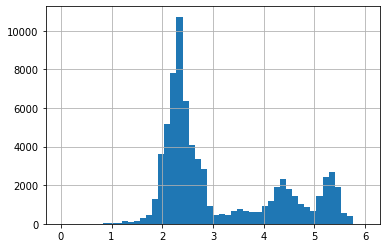

In [87]:
np.log10(dftest_all['predictions_test']+1).hist(bins=50,  range=[0,6])

<AxesSubplot:>

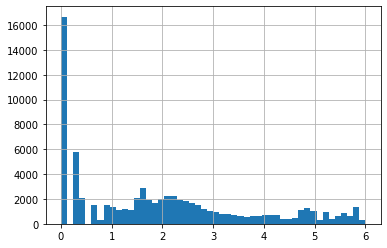

In [88]:
np.log10(dftest_all['timedelta']+1).hist(bins=50,  range=[0,6])

<AxesSubplot:>

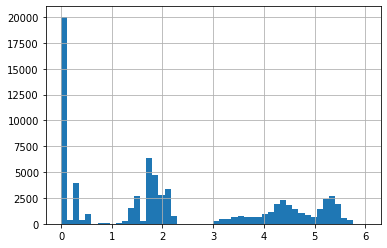

In [89]:
np.log10(dftest_all['predictions']+1).hist(bins=50,  range=[0,6])

C:\Users\20175892\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


<AxesSubplot:xlabel='timedelta', ylabel='predictions_test'>

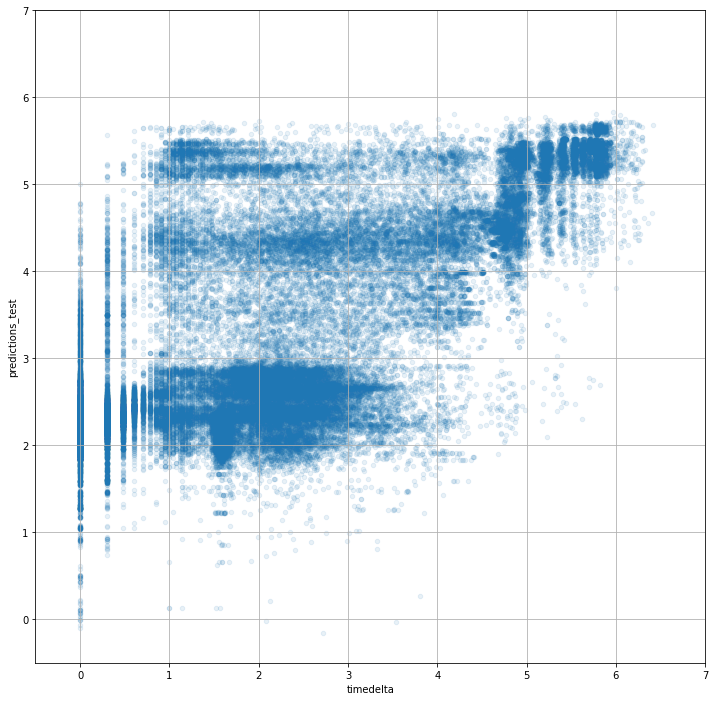

In [90]:
np.log10(dftest_all+1).plot.scatter(x='timedelta', y='predictions_test',alpha=0.1, figsize=(12,12), grid=True, ylim=(-.5,7), xlim=(-.5,7))

<AxesSubplot:xlabel='timedelta', ylabel='predictions'>

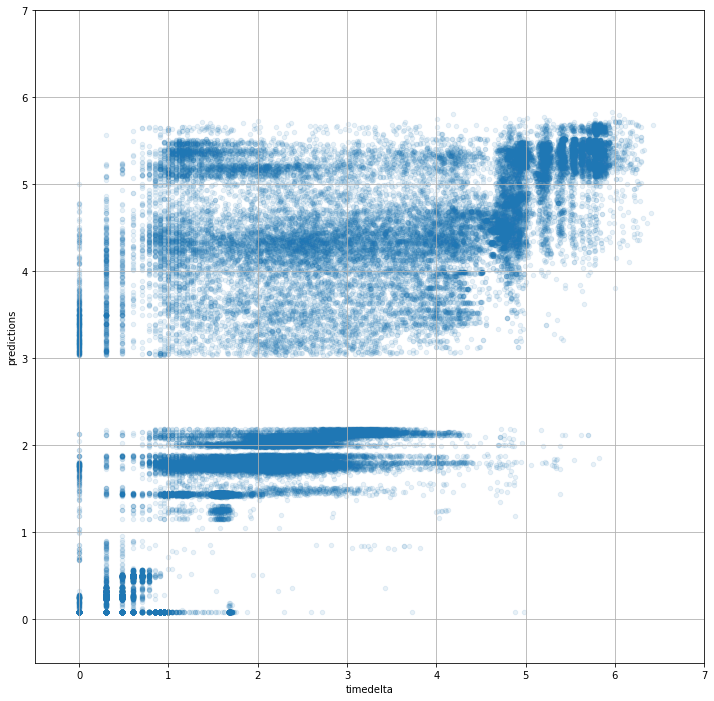

In [91]:
np.log10(dftest_all+1).plot.scatter(x='timedelta', y='predictions',alpha=0.1, figsize=(12,12), grid=True, ylim=(-.5,7), xlim=(-.5,7))

<AxesSubplot:xlabel='timedelta', ylabel='predictions'>

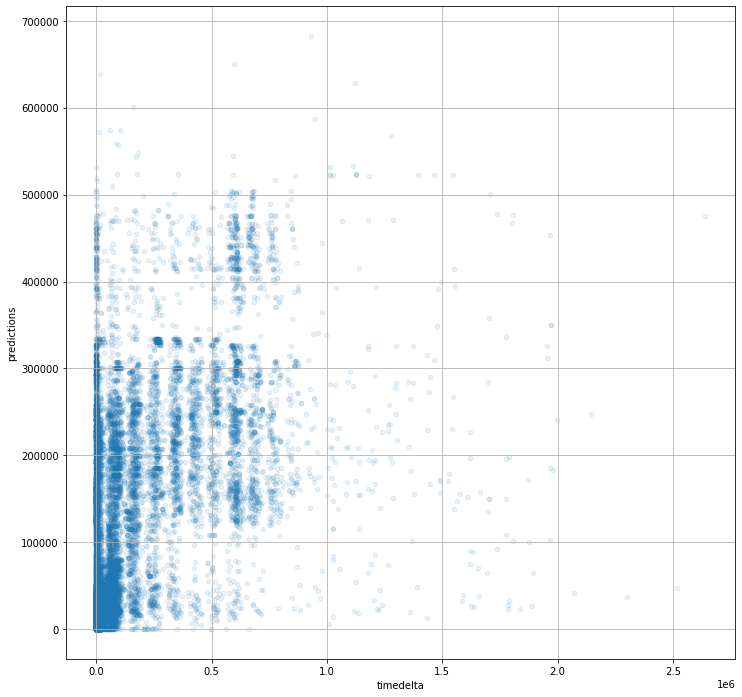

In [92]:
(dftest_all).plot.scatter(x='timedelta', y='predictions',alpha=0.1, figsize=(12,12), grid=True)

<AxesSubplot:xlabel='timedelta', ylabel='error'>

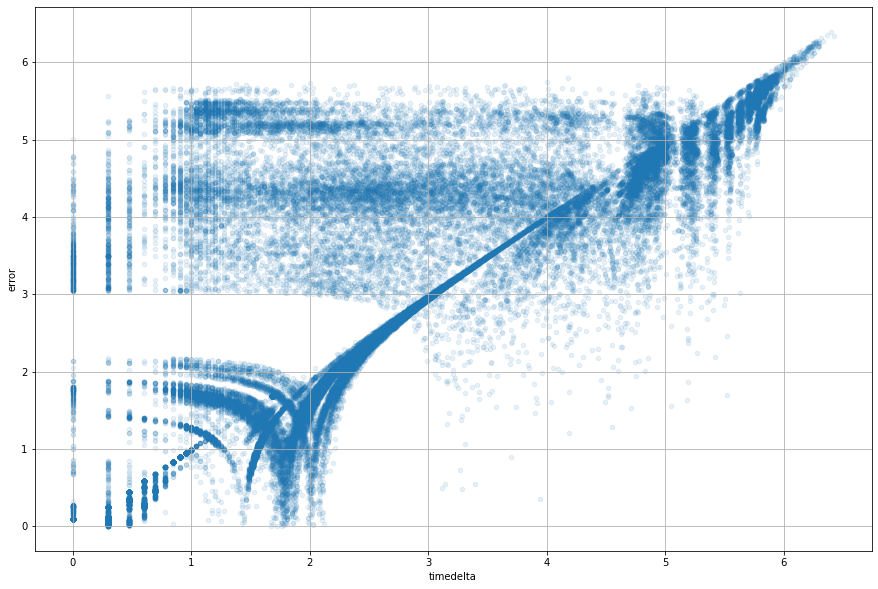

In [93]:
np.log10(dftest_all+1).plot.scatter(x='timedelta', y='error',alpha=0.1, figsize=(15,10), grid=True)

<AxesSubplot:xlabel='timedelta', ylabel='error'>

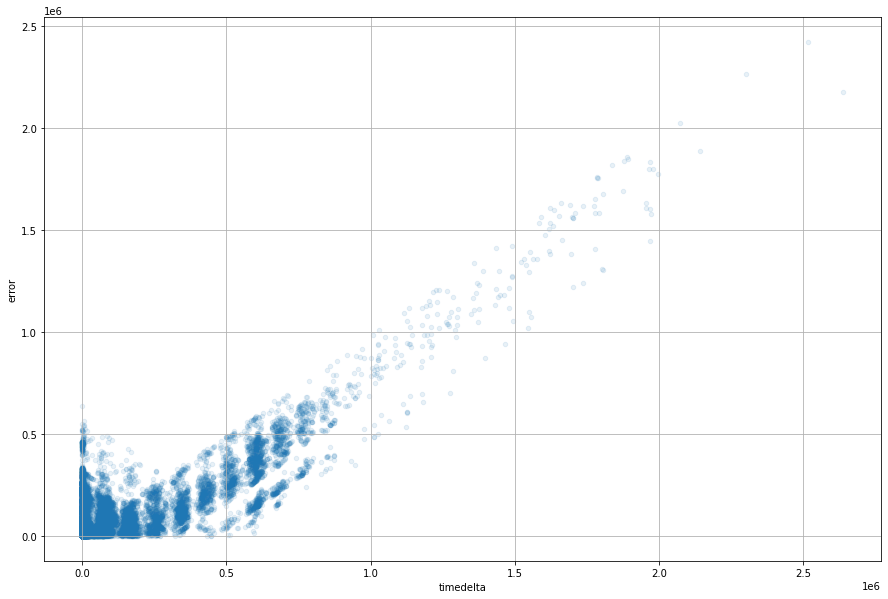

In [47]:
(dftest_all+1).plot.scatter(x='timedelta', y='error',alpha=0.1, figsize=(15,10), grid=True)

In [48]:
end2 = time.time()
print(end2-start)

116.65144801139832
